In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
from src.etl import SugarData
import pathlib

init_notebook_mode(connected=True)

local_path = pathlib.Path().resolve()

# Inro 
The purpose of the notebook to have a first look into the data 

# Read data

In [3]:
data = SugarData(local_path / "data" / "raw.csv")

INFO:root: __read_data [DONE], Resulting Data Shape=(2265, 19)
INFO:root: __clean_data [DONE], Resulting Data Shape=(2218, 3)
INFO:root: __glucose [DONE], Resulting Data Shape=(2031, 2)
INFO:root: __notes [DONE], Resulting Data Shape=(187, 2)


In [4]:
print(f"Start Date: {data.cleaned['datetime'].min()}")
print(f"End Date: {data.cleaned['datetime'].max()}")

Start Date: 2021-01-29 08:45:00
End Date: 2021-02-12 08:37:00


# Show Raw Measurements in time

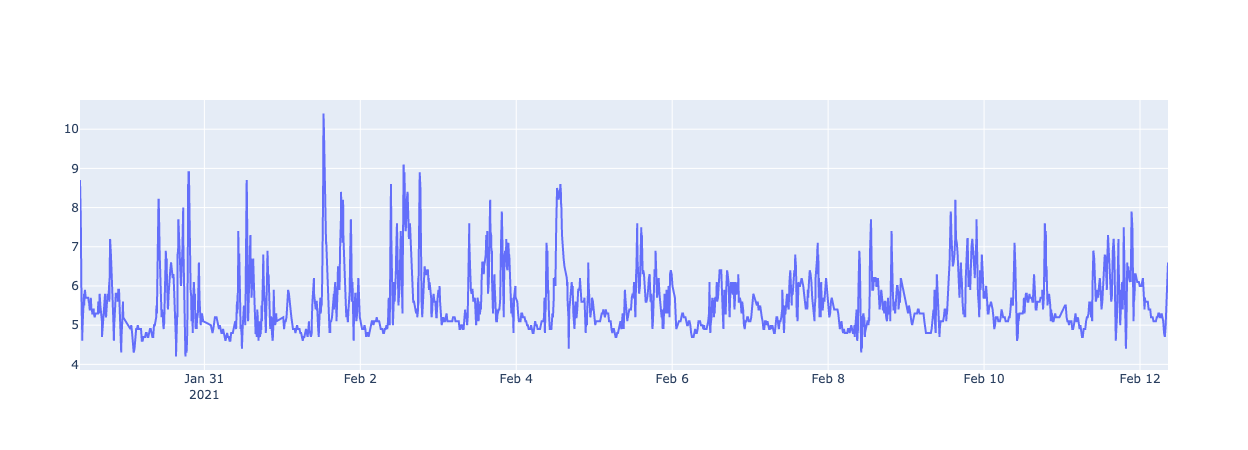

In [5]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=data.glucose["datetime"], y=data.glucose["glucose_level"]))

In [6]:
data.notes

,datetime,notes
0,2021-01-29 08:45:00,Oatmeal; sweet dried berries
1,2021-01-29 09:00:00,Coffee
6,2021-01-29 10:17:00,Feel hungry
12,2021-01-29 10:37:00,Handful almonds
24,2021-01-29 12:41:00,Salad; buffalo mozzarella; tomato
...,...,...
2138,2021-02-11 18:20:00,Bread 2; ham 2; cheese 2
2141,2021-02-11 18:30:00,Orange
2148,2021-02-11 19:29:00,Short yoga
2154,2021-02-11 20:04:00,Pear
